In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from IPython.display import display
from tqdm import tqdm
import torchsummary

batch_size = 8
# batch_size = 16
# batch_size = 32
# batch_size = 64
n_per_line = 10 # number of images to display per line
torch.manual_seed(41)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Horse to Zebra

In [2]:
image_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])

horse2zebra = ImageFolder("./data/horse2zebra/train/", image_transform)
dataloader = DataLoader(horse2zebra, batch_size=batch_size, shuffle=True)

horse2zebra_test = ImageFolder("./data/horse2zebra/test/", image_transform)
test_loader = DataLoader(horse2zebra_test, batch_size=n_per_line, shuffle=True)

## U-Net

In [3]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = self.conv_block(3, 64, 4, 2, 1) # 128 x 128
        self.conv2 = self.conv_block(64, 128, 4, 2, 1) # 64 x 64
        self.conv3 = nn.Conv2d(128, 256, 4, 2, 1) # 32 x 32

    def conv_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        z1 = self.conv1(x)
        z2 = self.conv2(z1)
        y = self.conv3(z2)
        return y, (z1, z2)


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = self.conv_block(256, 128, 4, 2, 1) # 64 x 64
        self.conv2 = self.conv_block(128 + 128, 64, 4, 2, 1) # 128 x 128
        self.conv3 = nn.ConvTranspose2d(64 + 64, 3, 4, 2, 1) # 256 x 256

    def conv_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, y, z):
        z1, z2 = z
        x = self.conv1(y)
        x = self.conv2(torch.cat([x, z2], dim=1))
        x = self.conv3(torch.cat([x, z1], dim=1))
        return x


class UNet(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y, z = self.encoder(x)
        x = self.decoder(y, z)
        x = self.sigmoid(x)
        return x

## Discriminator

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            self.conv_block(3, 64, 4, 2, 1), # 128 x 128
            self.conv_block(64, 128, 4, 2, 1), # 64 x 64
            self.conv_block(128, 256, 4, 2, 1), # 32 x 32
            self.conv_block(256, 512, 4, 2, 1), # 16 x 16
            nn.Conv2d(512, 1, 3, 1, 1), # 16 x 16
            nn.Sigmoid()
        )

    def conv_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        y = self.net(x)
        return y

## Training

In [5]:
# utils
L1 = nn.L1Loss()
MSE = nn.MSELoss()
BCE = nn.BCELoss()


def model_init(device=device):
    G = UNet(Encoder(), Decoder()).to(device)
    F = UNet(Encoder(), Decoder()).to(device)
    Dx = Discriminator().to(device)
    Dy = Discriminator().to(device)
    opt_gen = optim.Adam([*G.parameters(), *F.parameters()], lr=0.0002, betas=(0.5, 0.999))
    opt_disc = optim.Adam([*Dx.parameters(), *Dy.parameters()], lr=0.0002, betas=(0.5, 0.999))

    return G, F, Dx, Dy, opt_gen, opt_disc


def write_image(G, F, n_lines=1, size=128):
    G.eval(), F.eval()
    display_images = []
    with torch.no_grad():
        for _ in range(n_lines):
            images, labels = next(iter(test_loader))
            x = images[labels == 0].to(device)
            y = images[labels == 1].to(device)
            y_hat = G(x)
            x_hat = F(y)
            x_recon = F(y_hat)
            y_recon = G(x_hat)
            display_images.append(x)
            display_images.append(y)
            display_images.append(y_hat)
            display_images.append(x_hat)
            display_images.append(x_recon)
            display_images.append(y_recon)

            images = torch.cat(display_images, dim=0)
            images = transforms.Resize(size)(images)
            img = torchvision.utils.make_grid(images, n_per_line)
            img = transforms.functional.to_pil_image(img)
            display(img)


class ModeController:
    def __init__(self, G, F, Dx, Dy):
        self.G = G
        self.F = F
        self.Dx = Dx
        self.Dy = Dy

    def change(self, mode):
        if mode == 'gen':
            self.G.train()
            self.F.train()
            self.Dx.eval()
            self.Dy.eval()
            self.G.zero_grad()
            self.F.zero_grad()
            for p in self.G.parameters(): p.requires_grad = True
            for p in self.F.parameters(): p.requires_grad = True
            # for p in self.Dx.parameters(): p.requires_grad = False
            # for p in self.Dy.parameters(): p.requires_grad = False

        elif mode == 'disc':
            self.G.eval()
            self.F.eval()
            self.Dx.train()
            self.Dy.train()
            self.Dx.zero_grad()
            self.Dy.zero_grad()
            for p in self.G.parameters(): p.requires_grad = False
            for p in self.F.parameters(): p.requires_grad = False
            # for p in self.Dx.parameters(): p.requires_grad = True
            # for p in self.Dy.parameters(): p.requires_grad = True

In [6]:
def train(G, F, Dx, Dy, opt_gen, opt_disc, dataloader, n_epochs=10, lmd_i=1., lmd_c=1., lmd_a=1., disable=False, print_loss=True, write=True):
    mode_controller = ModeController(G, F, Dx, Dy)
    for epoch in range(n_epochs):
        for i, (images, labels) in enumerate(tqdm(dataloader, desc=f'Epoch {epoch+1}/{n_epochs}', disable=disable)):
            x = images[labels == 0].to(device) # horse
            y = images[labels == 1].to(device) # zebra
            if len(x) == 0 or len(y) == 0:
                continue
            fake_x = F(y)
            fake_y = G(x)

            # train generator
            mode_controller.change('gen')
            loss_idt_x = L1(x, fake_y) * lmd_i
            loss_idt_y = L1(y, fake_x) * lmd_i
            loss_cycle_G = L1(F(fake_y), x) * lmd_c
            loss_cycle_F = L1(G(fake_x), y) * lmd_c
            pred_fake_y = Dy(fake_y)
            pred_fake_x = Dy(fake_x)
            loss_adv_G = BCE(pred_fake_y, torch.ones_like(pred_fake_y)) * lmd_a
            loss_adv_F = BCE(pred_fake_x, torch.ones_like(pred_fake_x)) * lmd_a
            loss_gen = loss_idt_x + loss_idt_y + loss_cycle_G + loss_cycle_F + loss_adv_G + loss_adv_F
            loss_gen.backward()
            opt_gen.step()

            # train discriminator
            mode_controller.change('disc')
            # fake_x = F(y)
            # fake_y = G(x)

            pred_real = Dx(x)
            pred_fake = Dx(fake_x.detach())
            loss_real = BCE(pred_real, torch.ones_like(pred_real))
            loss_fake = BCE(pred_fake, torch.zeros_like(pred_fake))
            loss_Dx = loss_real + loss_fake
            loss_Dx.backward()

            pred_real = Dy(y)
            pred_fake = Dy(fake_y.detach())
            loss_real = BCE(pred_real, torch.ones_like(pred_real))
            loss_fake = BCE(pred_fake, torch.zeros_like(pred_fake))
            loss_Dy = loss_real + loss_fake
            loss_Dy.backward()

            opt_disc.step()


        if print_loss:
            print(f'loss_Dx: {loss_Dx:.4} | loss_Dy: {loss_Dy:.4f} | loss_gen: {loss_gen:.4f}')
        if write:
            write_image(G, F)

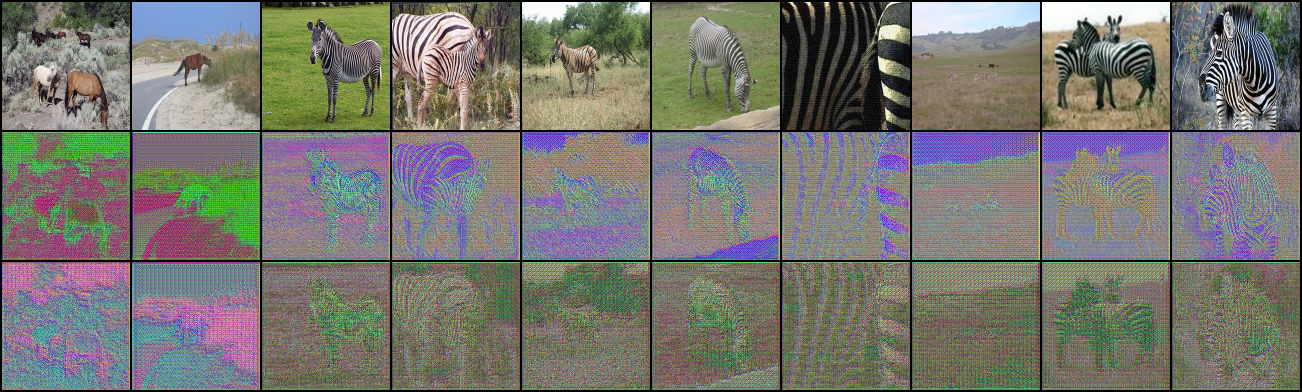

In [7]:
G, F, Dx, Dy, opt_gen, opt_disc = model_init()
write_image(G, F)

Epoch 1/3: 100%|██████████| 301/301 [00:22<00:00, 13.25it/s]


loss_Dx: 0.04667 | loss_Dy: 0.0247 | loss_gen: 8.6994


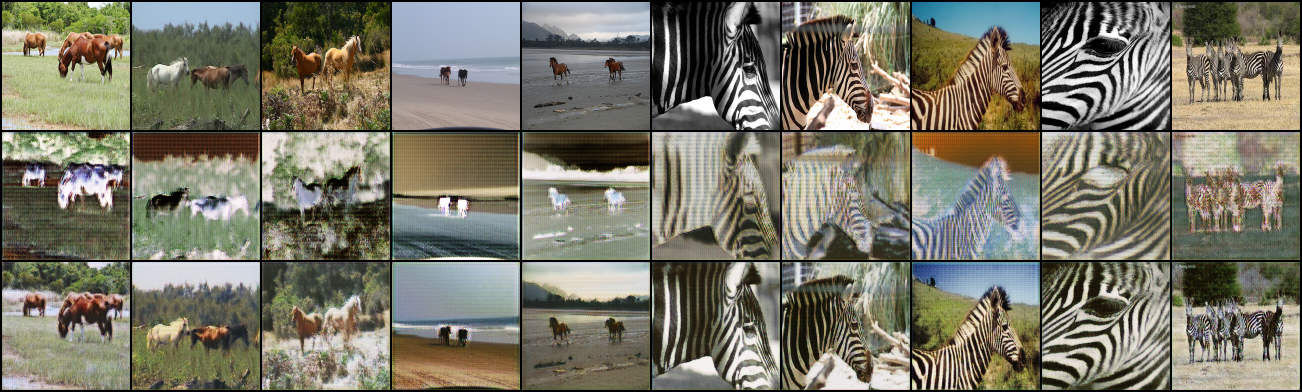

Epoch 2/3: 100%|██████████| 301/301 [00:22<00:00, 13.19it/s]


loss_Dx: 0.005388 | loss_Dy: 0.0075 | loss_gen: 8.7174


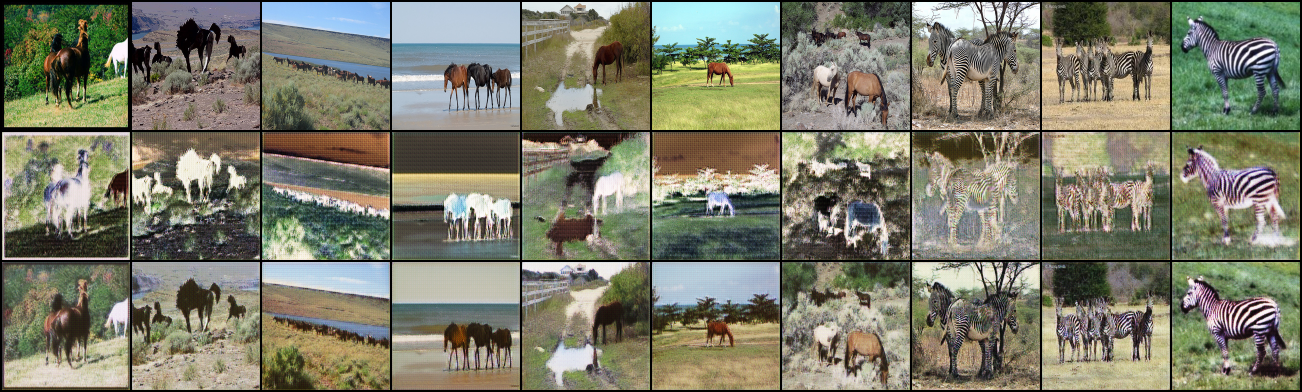

Epoch 3/3: 100%|██████████| 301/301 [00:22<00:00, 13.25it/s]

loss_Dx: 0.0205 | loss_Dy: 0.0139 | loss_gen: 9.0611


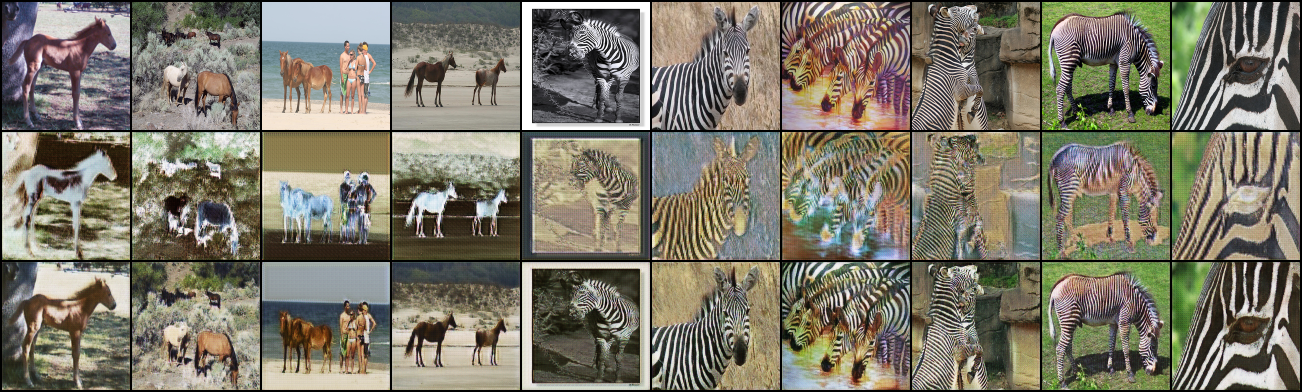

In [8]:
n_epochs = 3
train(G, F, Dx, Dy, opt_gen, opt_disc, dataloader, n_epochs, lmd_i=0.5, lmd_c=10.)

In [9]:
# n_epochs = 10
# train(G, F, Dx, Dy, opt_gen, opt_disc, dataloader, n_epochs, lmd=0.5)